In [1]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [2]:

# Loading the dataset
url = 'Dataset/BMRI_Cleaned.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-12-13,6025.0,6100.0,5975.0,6025.0,6025.0,135581400
2024-12-16,5900.0,6100.0,5900.0,6075.0,6075.0,105375900
2024-12-17,6050.0,6075.0,5925.0,5950.0,5950.0,72109300
2024-12-18,5925.0,6000.0,5775.0,5825.0,5825.0,153164600
2024-12-19,5625.0,5725.0,5600.0,5675.0,5675.0,277793000


Epoch 1/10
35/35 [==============================] - 5s 47ms/step - loss: 0.0147 - val_loss: 0.0088
Epoch 2/10
35/35 [==============================] - 1s 31ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 3/10
35/35 [==============================] - 1s 31ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 4/10
35/35 [==============================] - 1s 35ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/10
35/35 [==============================] - 1s 31ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 6/10
35/35 [==============================] - 1s 31ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 7/10
35/35 [==============================] - 1s 31ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 8/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 9/10
35/35 [==============================] - 1s 36ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/10
9/9 [==============================] - 0s 13ms/step - loss: 0.0033
Test Loss: 0.00325370905920863

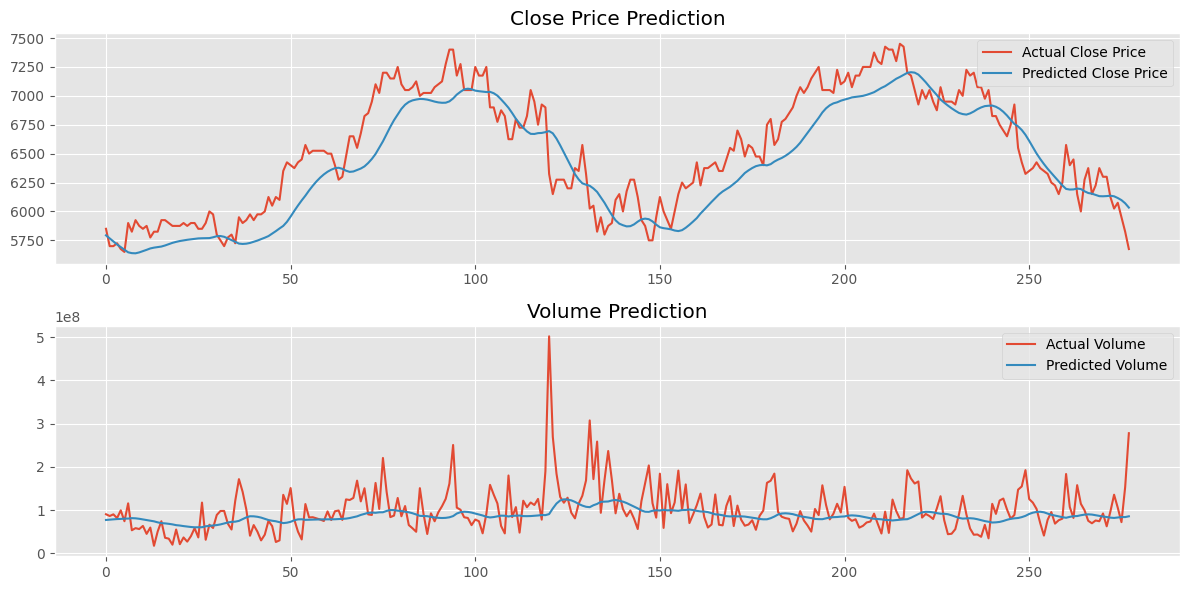

c:\Users\akhda\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Loading the dataset
url = 'Dataset/BMRI_Cleaned.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

data = df[['Close', 'Volume']]  # Select relevant columns: Open, Close, Volume

# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])  # X will have 60 days of historical data
        y.append(data[i, :])  # y will have the values of Close, Open, Volume on the next day
    return np.array(X), np.array(y)

look_back = 60  # Number of previous days to use for prediction

# Prepare the dataset
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add output layer with 3 units (Close, Open, Volume)
model.add(Dense(units=2))  # Predicting 3 features: Close, Open, Volume

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions on the test data
predicted_stock_prices = model.predict(X_test)

# Inverse transform the predictions to get the actual scale values
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

# Inverse transform the actual data to get the actual scale values
y_test_actual = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for Close, Open, and Volume
def calculate_metrics(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return rmse, mae, mape

# Calculate for Close, Open, and Volume
rmse_close, mae_close, mape_close = calculate_metrics(y_test_actual[:, 0], predicted_stock_prices[:, 0])
# rmse_open, mae_open, mape_open = calculate_metrics(y_test_actual[:, 0], predicted_stock_prices[:, 0])
rmse_volume, mae_volume, mape_volume = calculate_metrics(y_test_actual[:, 1], predicted_stock_prices[:, 1])

# Print evaluation metrics
print(f'Close - RMSE: {rmse_close:.4f}, MAE: {mae_close:.4f}, MAPE: {mape_close:.4f}%')
# print(f'Open - RMSE: {rmse_open:.4f}, MAE: {mae_open:.4f}, MAPE: {mape_open:.4f}%')
print(f'Volume - RMSE: {rmse_volume:.4f}, MAE: {mae_volume:.4f}, MAPE: {mape_volume:.4f}%')

# Plot the predictions vs actual values for Close, Open, and Volume
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted for Close, Open, and Volume
plt.subplot(2, 1, 1)
plt.plot(y_test_actual[:, 0], label='Actual Close Price')
plt.plot(predicted_stock_prices[:, 0], label='Predicted Close Price')
plt.legend()
plt.title('Close Price Prediction')

# plt.subplot(3, 1, 2)
# plt.plot(y_test_actual[:, 0], label='Actual Open Price')
# plt.plot(predicted_stock_prices[:, 0], label='Predicted Open Price')
# plt.legend()
# plt.title('Open Price Prediction')

plt.subplot(2, 1, 2)
plt.plot(y_test_actual[:, 1], label='Actual Volume')
plt.plot(predicted_stock_prices[:, 1], label='Predicted Volume')
plt.legend()
plt.title('Volume Prediction')

plt.tight_layout()
plt.show()

# Save the model
model.save('yahoo_stock_lstm_model_multivariate.h5')

# Load the model (optional)
from tensorflow.keras.models import load_model
loaded_model = load_model('yahoo_stock_lstm_model_multivariate.h5')


**Bidirectional LSTM**

Epoch 1/10
35/35 [==============================] - 8s 67ms/step - loss: 0.0135 - val_loss: 0.0054
Epoch 2/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/10
35/35 [==============================] - 1s 36ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 4/10
35/35 [==============================] - 1s 36ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 5/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 6/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 7/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 9/10
35/35 [==============================] - 1s 36ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/10
9/9 [==============================] - 0s 12ms/step - loss: 0.0038
Test Loss (Bidirectional LSTM)

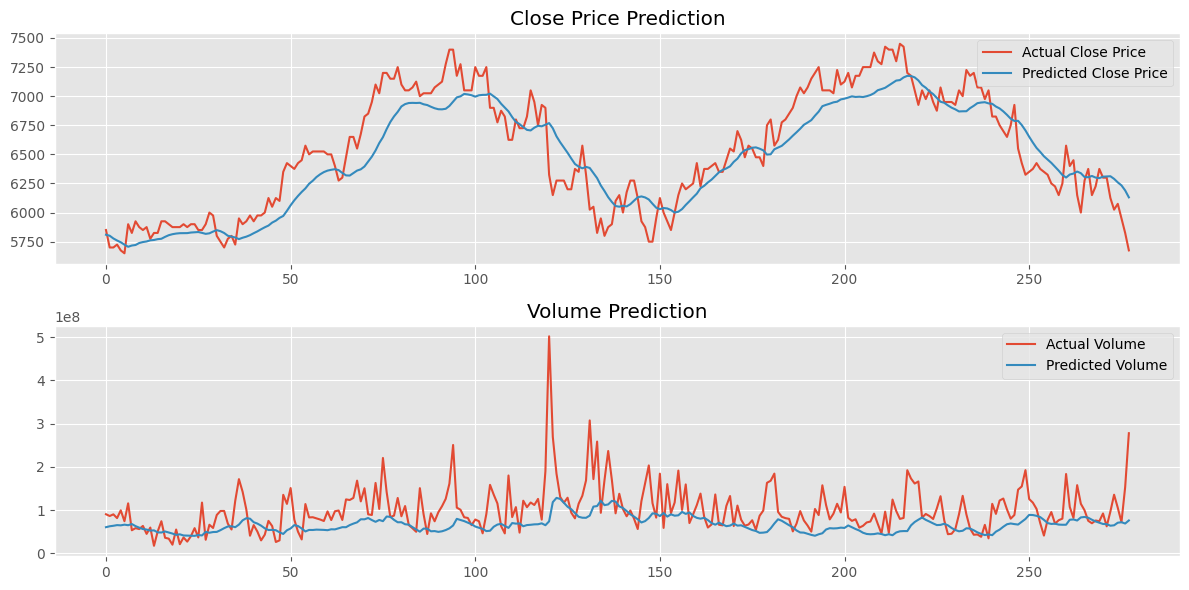

c:\Users\akhda\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Loading the dataset
url = 'Dataset/BMRI_Cleaned.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

data = df[['Close', 'Volume']]  # Select relevant columns: Open, Close, Volume

# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])  # X will have 60 days of historical data
        y.append(data[i, :])  # y will have the values of Close, Open, Volume on the next day
    return np.array(X), np.array(y)

look_back = 60  # Number of previous days to use for prediction

# Prepare the dataset
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from tensorflow.keras.layers import Bidirectional

# Build the Bidirectional LSTM model
model_bi = Sequential()

# Add Bidirectional LSTM layer
model_bi.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bi.add(Bidirectional(LSTM(units=50, return_sequences=False)))

# Add Dropout layer to prevent overfitting
model_bi.add(Dropout(0.2))

# Add output layer with 2 units (Close, Volume)
model_bi.add(Dense(units=2))

# Compile the model
model_bi.compile(optimizer='adam', loss='mean_squared_error')

# Train the Bidirectional LSTM model
history_bi = model_bi.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss_bi = model_bi.evaluate(X_test, y_test)
print(f'Test Loss (Bidirectional LSTM): {test_loss_bi}')

# Make predictions on the test data
predicted_stock_prices_bi = model_bi.predict(X_test)

# Inverse transform the predictions to get the actual scale values
predicted_stock_prices_bi = scaler.inverse_transform(predicted_stock_prices_bi)

# Inverse transform the actual data to get the actual scale values
y_test_actual = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for Close, Open, and Volume
def calculate_metrics(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return rmse, mae, mape

# Calculate for Close, Open, and Volume
rmse_close, mae_close, mape_close = calculate_metrics(y_test_actual[:, 0], predicted_stock_prices_bi[:, 0])
# rmse_open, mae_open, mape_open = calculate_metrics(y_test_actual[:, 0], predicted_stock_prices[:, 0])
rmse_volume, mae_volume, mape_volume = calculate_metrics(y_test_actual[:, 1], predicted_stock_prices_bi[:, 1])

# Print evaluation metrics
print(f'Close - RMSE: {rmse_close:.4f}, MAE: {mae_close:.4f}, MAPE: {mape_close:.4f}%')
# print(f'Open - RMSE: {rmse_open:.4f}, MAE: {mae_open:.4f}, MAPE: {mape_open:.4f}%')
print(f'Volume - RMSE: {rmse_volume:.4f}, MAE: {mae_volume:.4f}, MAPE: {mape_volume:.4f}%')

# Plot the predictions vs actual values for Close, Open, and Volume
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted for Close, Open, and Volume
plt.subplot(2, 1, 1)
plt.plot(y_test_actual[:, 0], label='Actual Close Price')
plt.plot(predicted_stock_prices_bi[:, 0], label='Predicted Close Price')
plt.legend()
plt.title('Close Price Prediction')

# plt.subplot(3, 1, 2)
# plt.plot(y_test_actual[:, 0], label='Actual Open Price')
# plt.plot(predicted_stock_prices[:, 0], label='Predicted Open Price')
# plt.legend()
# plt.title('Open Price Prediction')

plt.subplot(2, 1, 2)
plt.plot(y_test_actual[:, 1], label='Actual Volume')
plt.plot(predicted_stock_prices_bi[:, 1], label='Predicted Volume')
plt.legend()
plt.title('Volume Prediction')

plt.tight_layout()
plt.show()

# Save the model
model.save('yahoo_stock_bidirectional_lstm_model_multivariate.h5')

# Load the model (optional)
from tensorflow.keras.models import load_model
loaded_model = load_model('yahoo_stock_bidirectional_lstm_model_multivariate.h5')


**Stacked LSTM**

Epoch 1/10
35/35 [==============================] - 6s 67ms/step - loss: 0.0120 - val_loss: 0.0057
Epoch 2/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0054 - val_loss: 0.0077
Epoch 3/10
35/35 [==============================] - 2s 47ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 4/10
35/35 [==============================] - 2s 46ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 5/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 6/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 7/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 8/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 9/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 10/10
9/9 [==============================] - 0s 15ms/step - loss: 0.0036
Test Loss (Stacked LSTM): 0.00

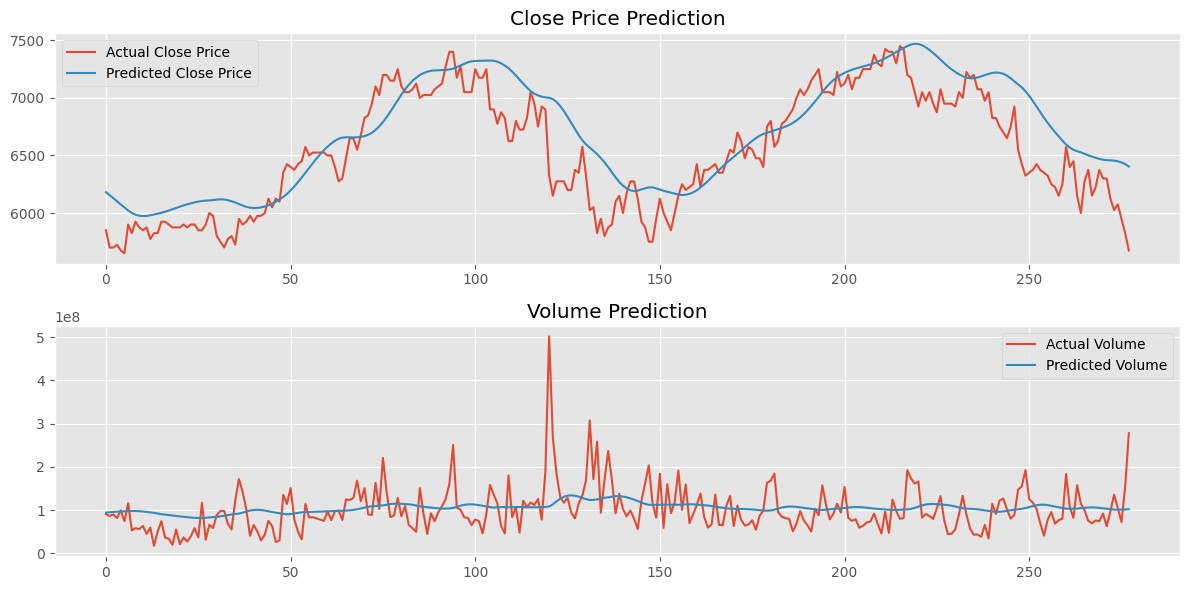

c:\Users\akhda\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Loading the dataset
url = 'Dataset/BMRI_Cleaned.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

data = df[['Close', 'Volume']]  # Select relevant columns: Open, Close, Volume

# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])  # X will have 60 days of historical data
        y.append(data[i, :])  # y will have the values of Close, Open, Volume on the next day
    return np.array(X), np.array(y)

look_back = 60  # Number of previous days to use for prediction

# Prepare the dataset
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the Stacked LSTM model
model_stacked = Sequential()

# Add first LSTM layer
model_stacked.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add second LSTM layer
model_stacked.add(LSTM(units=50, return_sequences=True))

# Add third LSTM layer
model_stacked.add(LSTM(units=50, return_sequences=False))

# Add Dropout layer to prevent overfitting
model_stacked.add(Dropout(0.2))

# Add output layer with 2 units (Close, Volume)
model_stacked.add(Dense(units=2))

# Compile the model
model_stacked.compile(optimizer='adam', loss='mean_squared_error')

# Train the Stacked LSTM model
history_stacked = model_stacked.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss_stacked = model_stacked.evaluate(X_test, y_test)
print(f'Test Loss (Stacked LSTM): {test_loss_stacked}')

# Make predictions on the test data
predicted_stock_prices_stacked = model_stacked.predict(X_test)

# Inverse transform the predictions to get the actual scale values
predicted_stock_prices_stacked = scaler.inverse_transform(predicted_stock_prices_stacked)

# Inverse transform the actual data to get the actual scale values
y_test_actual = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for Close, Open, and Volume
def calculate_metrics(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return rmse, mae, mape

# Calculate for Close, Open, and Volume
rmse_close, mae_close, mape_close = calculate_metrics(y_test_actual[:, 0], predicted_stock_prices_stacked[:, 0])
# rmse_open, mae_open, mape_open = calculate_metrics(y_test_actual[:, 0], predicted_stock_prices[:, 0])
rmse_volume, mae_volume, mape_volume = calculate_metrics(y_test_actual[:, 1], predicted_stock_prices_stacked[:, 1])

# Print evaluation metrics
print(f'Close - RMSE: {rmse_close:.4f}, MAE: {mae_close:.4f}, MAPE: {mape_close:.4f}%')
# print(f'Open - RMSE: {rmse_open:.4f}, MAE: {mae_open:.4f}, MAPE: {mape_open:.4f}%')
print(f'Volume - RMSE: {rmse_volume:.4f}, MAE: {mae_volume:.4f}, MAPE: {mape_volume:.4f}%')

# Plot the predictions vs actual values for Close, Open, and Volume
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted for Close, Open, and Volume
plt.subplot(2, 1, 1)
plt.plot(y_test_actual[:, 0], label='Actual Close Price')
plt.plot(predicted_stock_prices_stacked[:, 0], label='Predicted Close Price')
plt.legend()
plt.title('Close Price Prediction')

# plt.subplot(3, 1, 2)
# plt.plot(y_test_actual[:, 0], label='Actual Open Price')
# plt.plot(predicted_stock_prices[:, 0], label='Predicted Open Price')
# plt.legend()
# plt.title('Open Price Prediction')

plt.subplot(2, 1, 2)
plt.plot(y_test_actual[:, 1], label='Actual Volume')
plt.plot(predicted_stock_prices_stacked[:, 1], label='Predicted Volume')
plt.legend()
plt.title('Volume Prediction')

plt.tight_layout()
plt.show()

# Save the model
model.save('yahoo_stock_stacked_lstm_model_multivariate.h5')

# Load the model (optional)
from tensorflow.keras.models import load_model
loaded_model = load_model('yahoo_stock_stacked_lstm_model_multivariate.h5')


In [6]:

# Correlation matrix
df.corr()['Close']

Open         0.998572
High         0.999377
Low          0.999360
Close        1.000000
Adj Close    0.992806
Volume      -0.079525
Name: Close, dtype: float64

In [7]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    1.450000e+03
mean     1.030403e+08
std      6.034743e+07
min      5.985400e+06
25%      6.486758e+07
50%      8.950520e+07
75%      1.259858e+08
max      7.702524e+08
Name: Volume, dtype: float64


In [8]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [9]:
#Build and train the model
def fit_model(train,val,timesteps,hl,learning_rate,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(3))
    model.compile(optimizer = optimizers.Adam(learning_rate = learning_rate), loss = 'mean_squared_error')
    #print(model.summary())

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    # model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [10]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)

    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [11]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [12]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### **Model Building**

In [13]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(1450, 3)
             Close    High     Volume
Date                                 
2024-12-13  6025.0  6100.0  135581400
2024-12-16  6075.0  6100.0  105375900
2024-12-17  5950.0  6075.0   72109300
2024-12-18  5825.0  6000.0  153164600
2024-12-19  5675.0  5725.0  277793000


In [14]:

# Train Val Test Split
train_start = dt.date(2023,11,1)
train_end = dt.date(2024,9,30)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2024,10,1)
val_end = dt.date(2024,11,29)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2024,10,1)
test_end = dt.date(2024,11,29)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(216, 3) (43, 3) (43, 3)


In [15]:
# Tanpa Normalisation
train = train_data
val = val_data
test = test_data
print(train.shape,val.shape,test.shape)

(216, 3) (43, 3) (43, 3)


In [16]:
timesteps = 10
hl = [40,35]
learning_rate = 1e-3
batch_size = 64
epochs = 50


In [17]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,learning_rate,batch_size,epochs)
plot_error(train_error,val_error)

KeyError: 10

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
# plot_data(true,predicted)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE = 0.03759694025657699
RMSE = 0.19389930442520156
R-Squared Score = -1.6309229158496077


In [ ]:
# Save a model
# model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
#del model # Deletes the model
# Load a model
model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')

**Cross-Validation**

In [ ]:
# Hyperparameters
timesteps = 50
hl = [40,35]
learning_rate = 1e-3
batch_size = 64
epochs = 50

In [ ]:

# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series
print(series.shape)
print(series.tail())

(1435, 3)
              Close     High     Volume
Date                                   
2024-11-22   9850.0   9950.0   58396100
2024-11-25  10175.0  10200.0  165369400
2024-11-26  10000.0  10250.0   62310100
2024-11-28  10000.0  10075.0   57443500
2024-11-29  10000.0  10100.0   76886000


In [ ]:

# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.12423313, 0.07235772, 0.03392713],
       [0.11503067, 0.06829268, 0.08273793],
       [0.11886503, 0.06585366, 0.05472288],
       ...,
       [0.85429448, 0.88617886, 0.06926488],
       [0.85429448, 0.85772358, 0.06273934],
       [0.85429448, 0.86178862, 0.08880944]])

Split 1

In [ ]:

#Splitting the data for initial model creation
splits = 2
split_size = 70
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

In [ ]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,timesteps,hl,learning_rate,batch_size,epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-LSTM-Split1.h5")

TypeError: fit_model() missing 1 required positional argument: 'epochs'